In [2]:
import numpy as np
import csv
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import math
import warnings
import pandas as pd
from scipy.optimize import minimize
import scipy.stats
from scipy.special import log_ndtr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.feature_selection import f_regression
from tobit import *


# choose statistical or biochemical epistasis
ab = 'CB6'
replicates = ['i', 'j']

# ab = 'REGN10987'
# replicates = ['g', 'h']

# ab = 'S309'
# replicates = ['c', 'd']

# ab = 'CoV555'
# replicates = ['e', 'v']

L = 15
mutations = [str(x) for x in range(L)]

ep_type = 'biochem'
antibody = ab
df = pd.read_csv(f'../Titeseq/results/Kds/cleaned_Kds_RBD_{ab}.tsv', sep="\t", dtype={'geno': str})

In [3]:
# clean up:
import re
df[f"max_fluo"] = df[[a for a in df.keys() if re.match(f"mean_log10PE_*", a) is not None]].max(axis=1)
df[f"min_fluo"] = df[[a for a in df.keys() if re.match(f"mean_log10PE_*", a) is not None]].min(axis=1)
df[f"difference"] = df[f"max_fluo"] - df[f"min_fluo"]
df["is_non_binder"] = df.difference < 1

df["is_clean"] = ((df[f"r2_{replicates[0]}"] > 0.8) & (df[f"sigma_{replicates[0]}"] < 1) &
                  (df[f"r2_{replicates[1]}"] > 0.8) & (df[f"sigma_{replicates[1]}"] < 1))

/n/helmod/apps/centos7/Core/Anaconda3/2021.05-jupyterood-fasrc01/x/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/n/helmod/apps/centos7/Core/Anaconda3/2021.05-jupyterood-fasrc01/x/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


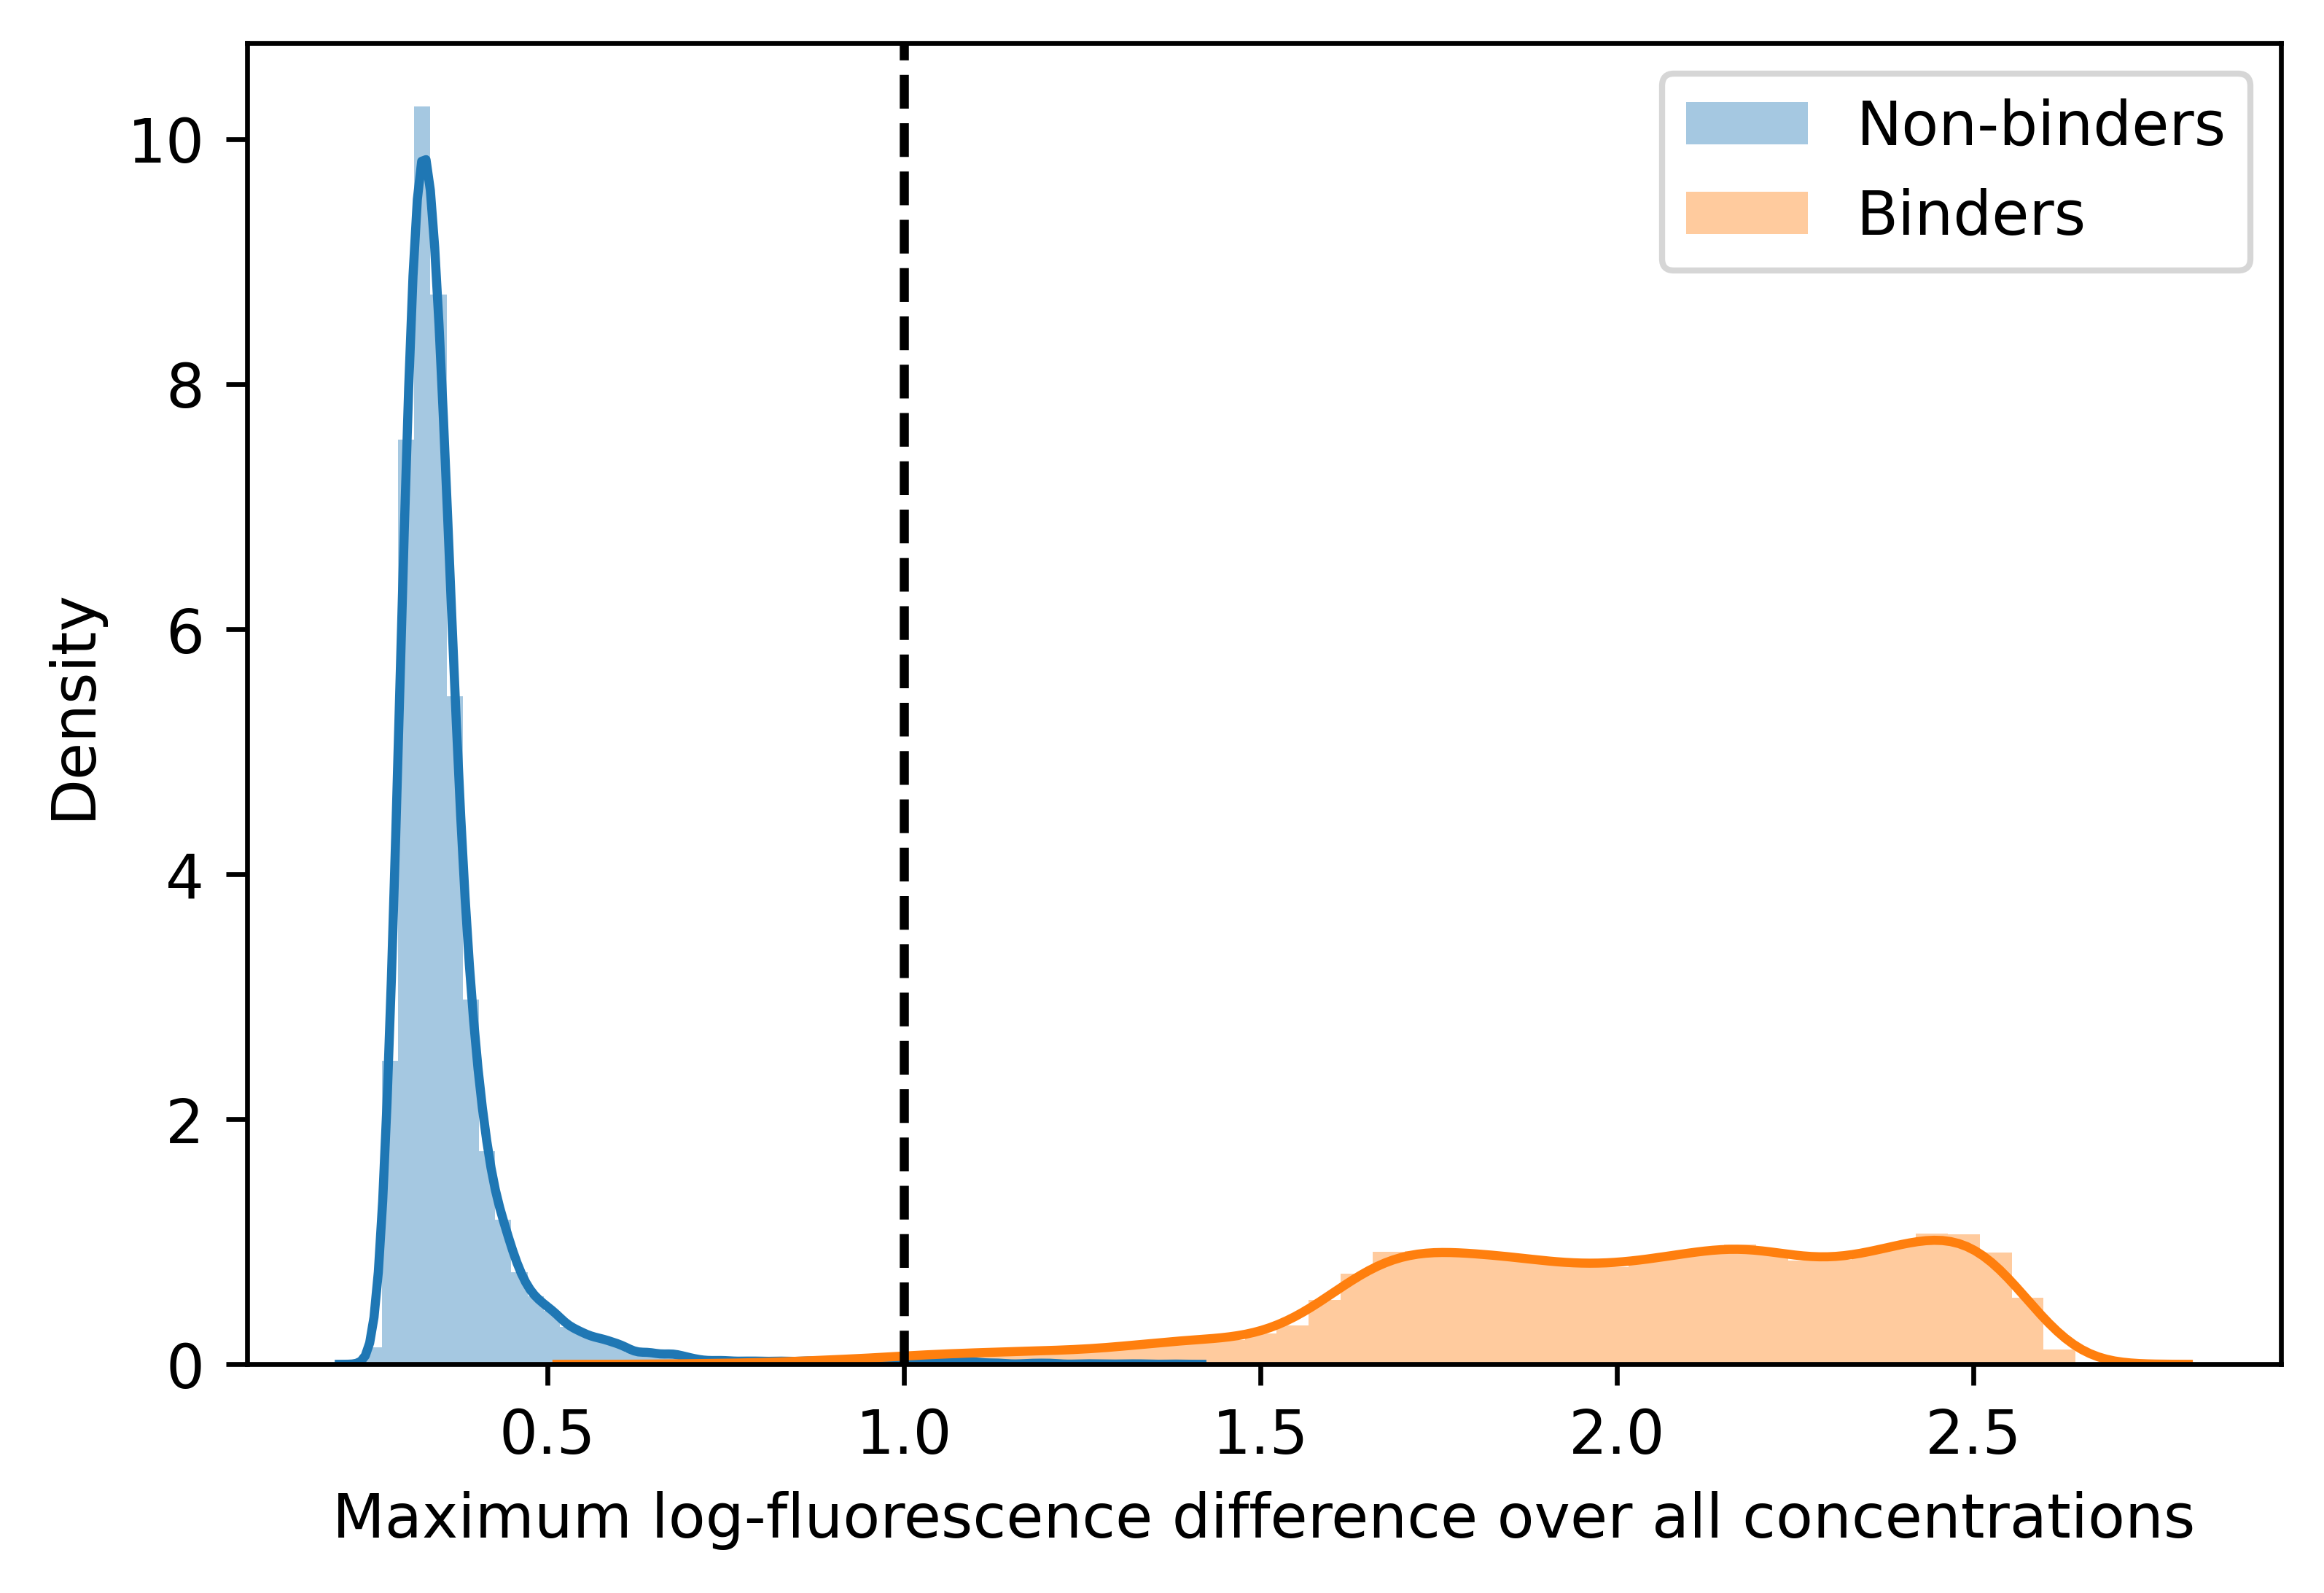

In [4]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=600)
sns.distplot(df[df.geno.str[4] == '1'].difference, ax=ax, label='Non-binders')
sns.distplot(df[df.geno.str[4] == '0'].difference, ax=ax, label='Binders')
ax.set_xlabel('Maximum log-fluorescence difference over all concentrations')
ax.axvline(1, c='k', ls='dashed')
plt.legend()
plt.savefig("FigureSX_binders_nonbinders.pdf")

In [58]:

import scipy.linalg
from tqdm.notebook import tqdm
import tobit

# set up permutation
np.random.seed(2112)
rng = np.random.default_rng()
nb_bootstrap = 5
cens_value = 7
dfc = df[(df.is_clean) | (df.is_non_binder)]
coeffs, coeffs_lin, poly_train, poly_test, coeffs_names, poly = {}, {}, {}, {}, {}, {}

for kk in tqdm(range(nb_bootstrap)):
    tr = TobitModel(fit_intercept=False, lower=cens_value, ε=0.01)
    L = len(df)
    phenos = (dfc.log10Kd + rng.standard_normal(size=len(dfc))*dfc.err_log10Kd).to_numpy()
    genos = np.array(dfc.geno.apply(lambda x: [float(a) for a in x]).to_list())
    genos_string = dfc.geno.to_list()
    cens = (dfc.is_non_binder.map({True: -1, False:0})).to_numpy()
    
    # permute indices
    indices_permuted = rng.permutation(np.arange(len(genos)))
    genos_permuted = genos[indices_permuted]
    phenos_permuted = phenos[indices_permuted]
    cens_permuted = cens[indices_permuted]
    
    # create train & test sets
    
    n = L//2
    genos_train = genos_permuted[:n]
    cens_train = cens_permuted[:n]
    genos_test = genos_permuted[n:]
    phenos_train = phenos_permuted[:n]
    phenos_test = phenos_permuted[n:]

    # test with only the pairs
    # indices = [ii for ii, a in enumerate(genos) if a.sum() <= 1]
    # n = len(indices)
    # rev_indices = [ii for ii, a in enumerate(genos) if a.sum() > 1]
    # genos_train = genos[indices]
    # phenos_train = phenos[indices]
    # genos_test = genos[rev_indices]
    # phenos_test = phenos[rev_indices]
    
    for order in range(1, 5):
        poly[order] = PolynomialFeatures(order, interaction_only=True)
        poly_train[order] = poly[order].fit_transform(genos_train)
        poly_test[order] = poly[order].fit_transform(genos_test)
        phenos_train = np.where(np.isnan(phenos_train) | (phenos_train < cens_value),
                                             cens_value, phenos_train)
        
        regs = tr.fit(pd.DataFrame(poly_train[order]), pd.Series(phenos_train), pd.Series(cens_train), 
                          verbose=False)
        coeffs[order, kk] = regs.coef_
        coeffs_lin[order, kk] = scipy.linalg.lstsq(poly_train[order], phenos_train, lapack_driver='gelsy')[0]
        coeffs_names[order] = poly[order].get_feature_names()

  0%|          | 0/5 [00:00<?, ?it/s]

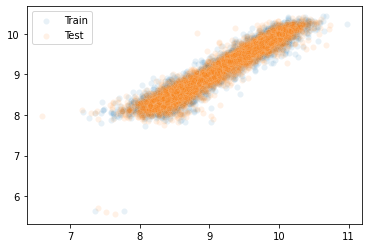

In [59]:
order = 4
sns.scatterplot(x=phenos_train[phenos_train != cens_value], y=(poly_train[order]@coeffs[order, 0])[phenos_train != cens_value], label="Train", alpha=0.1)
sns.scatterplot(x=phenos_test, y=poly_test[order]@coeffs[order, 0], alpha=0.1, label="Test")
plt.legend()

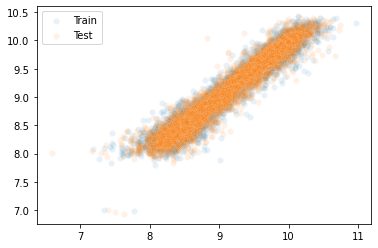

In [60]:
sns.scatterplot(x=phenos_train[phenos_train != cens_value], y=(poly_train[order]@coeffs_lin[order, 0])[phenos_train != cens_value], label="Train", alpha=0.1)
sns.scatterplot(x=phenos_test, y=poly_test[order]@coeffs_lin[order, 0], alpha=0.1, label="Test")
plt.legend()

In [61]:
phenos_test_corr = np.where(np.isnan(phenos_test) | (phenos_test < cens_value),
                                             cens_value, phenos_test)
print(r2_score(phenos_test_corr, poly_test[order]@coeffs_lin[order, 0]))

phenos_test_inferred = poly_test[order]@coeffs[order, 0]
phenos_test_inferred = np.where(np.isnan(phenos_test_inferred) | (phenos_test_inferred < cens_value),
                                             cens_value, phenos_test_inferred)
print(r2_score(phenos_test_corr, phenos_test_inferred))

0.9910823883190405
0.9910289377575288


<ipython-input-62-4f3c120a6cfa>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfc["inferred_value"] = poly_all@coeffs[order, 0]
<ipython-input-62-4f3c120a6cfa>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfc["is_non_binder_inf"] = dfc.inferred_value < cens_value


0.9957025411061285


/n/helmod/apps/centos7/Core/Anaconda3/2021.05-jupyterood-fasrc01/x/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/n/helmod/apps/centos7/Core/Anaconda3/2021.05-jupyterood-fasrc01/x/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/n/helmod/apps/centos7/Core/Anaconda3/2021.05-jupyterood-fasrc01/x/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will 

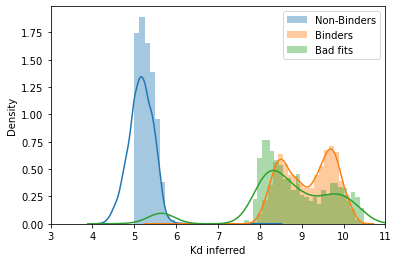

In [62]:

genos = np.array(dfc.geno.apply(lambda x: [float(a) for a in x]).to_list())
poly_all = poly[order].fit_transform(genos)

dfc["inferred_value"] = poly_all@coeffs[order, 0]
dfc["is_non_binder_inf"] = dfc.inferred_value < cens_value
print(accuracy_score(dfc.is_non_binder, dfc.is_non_binder_inf))

phenos_test_inferred = poly_test[order]@coeffs[order, 0]



genos = np.array(df.geno.apply(lambda x: [float(a) for a in x]).to_list())
poly_all = poly[order].fit_transform(genos)
sns.distplot((phenos_test_inferred)[pd.isna(phenos_test)], label="Non-Binders", bins=np.linspace(5, 11, 50))
sns.distplot((phenos_test_inferred)[~pd.isna(phenos_test)], label="Binders", bins=np.linspace(5, 11, 50)).set_xlabel("Kd inferred")
sns.distplot((poly_all@coeffs[order, 0])[~((df.is_clean) | (df.is_non_binder))], label="Bad fits", bins=np.linspace(6, 11, 50)).set_xlabel("Kd inferred")
plt.xlim((3, 11))
plt.legend()

In [63]:
dfcoef = {}
for order in coeffs_names:
    dfcoef[order] = pd.DataFrame()
    dfcoef[order]["coef_name"] = coeffs_names[order]
    for k in range(nb_bootstrap):
        dfcoef[order][f"coef_tobit_{k}"] = coeffs[order, k]
        dfcoef[order][f"coef_lin_{k}"] = coeffs_lin[order, k]
    dfcoef[order][f"mean_coef_tobit"] = [np.mean([coeffs[order, k][ii] for k in range(nb_bootstrap)]) for ii in range(len(coeffs[order, 0]))]
    dfcoef[order][f"ste_coef_tobit"] = [np.std([coeffs[order, k][ii] for k in range(nb_bootstrap)])/np.sqrt(nb_bootstrap-1) for ii in range(len(coeffs[order, 0]))]
    dfcoef[order][f"mean_coef_lin"] = [np.mean([coeffs_lin[order, k][ii] for k in range(nb_bootstrap)]) for ii in range(len(coeffs[order, 0]))]
    dfcoef[order][f"ste_coef_lin"] = [np.std([coeffs_lin[order, k][ii] for k in range(nb_bootstrap)])/np.sqrt(nb_bootstrap-1) for ii in range(len(coeffs[order, 0]))]
    dfcoef[order]["epistatic_order"] = dfcoef[order]["coef_name"].str.count("x")
    dfcoef[order] = dfcoef[order].copy()

/n/helmod/apps/centos7/Core/Anaconda3/2021.05-jupyterood-fasrc01/x/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'All coefficients')

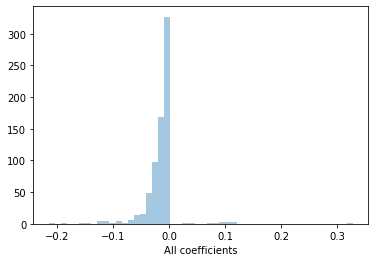

In [64]:
data = dfcoef[order][(dfcoef[order][f"ste_coef_tobit"]/dfcoef[order][f"mean_coef_tobit"] < 0.1)
              & (dfcoef[order]["epistatic_order"] == 4)]
sns.distplot(data["mean_coef_tobit"], kde=False).set_xlabel("All coefficients")

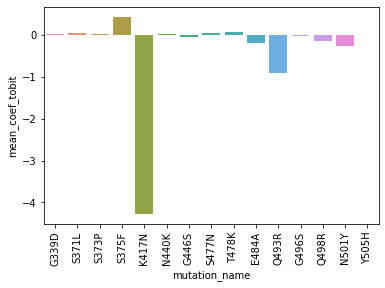

In [65]:
mutation_name = ["G339D","S371L","S373P","S375F","K417N","N440K","G446S","S477N","T478K","E484A","Q493R","G496S","Q498R","N501Y","Y505H"]
data = dfcoef[order][(dfcoef[order][f"ste_coef_tobit"]/dfcoef[order][f"mean_coef_tobit"] < 1)
              & (dfcoef[order]["epistatic_order"] == 1)].copy()
data["mutation_name"] = data.coef_name.apply(lambda x: mutation_name[int(x[1:])])
sns.barplot(x="mutation_name", y="mean_coef_tobit", data=data, order=mutation_name)
plt.xticks(rotation=90);

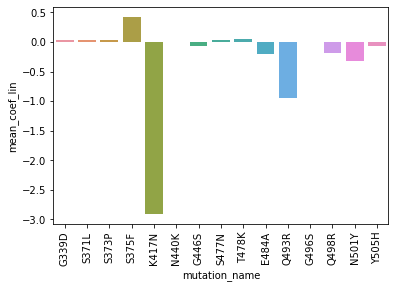

In [66]:
mutation_name = ["G339D","S371L","S373P","S375F","K417N","N440K","G446S","S477N","T478K","E484A","Q493R","G496S","Q498R","N501Y","Y505H"]
data = dfcoef[order][(dfcoef[order][f"ste_coef_lin"]/dfcoef[order][f"mean_coef_lin"] < 1)
              & (dfcoef[order]["epistatic_order"] == 1)].copy()
data["mutation_name"] = data.coef_name.apply(lambda x: mutation_name[int(x[1:])])
sns.barplot(x="mutation_name", y="mean_coef_lin", data=data, order=mutation_name)
plt.xticks(rotation=90);

In [69]:
sum_3rd_order = {}
for i in range(15):
    sum_3rd_order[i] = dfcoef[order][(dfcoef[order].epistatic_order == 3)
                                  & ((dfcoef[order].coef_name.str.contains(f" x{i}"))|
                                     (dfcoef[order].coef_name.str.contains(f"x{i} ")))].mean_coef_tobit.sum()

In [70]:
sum_3rd_order

{0: 0.1951126344953102,
 1: 2.2499807183763574,
 2: -0.4868214446982587,
 3: -0.0659837147490643,
 4: -0.19000616954596014,
 5: 0.31143423051799624,
 6: 0.7457837295808555,
 7: 0.7133913109555097,
 8: 0.5093949558062695,
 9: 0.7592696850612158,
 10: 0.8725660054833955,
 11: -0.2034150874530702,
 12: 1.370956293016909,
 13: 1.0120862387245952,
 14: 0.8081452732453942}

In [71]:
for od in dfcoef:
    dfcoef[od].to_csv(f"{ab}_{od}_csv_coef.tsv", sep="\t")

In [72]:
for od in dfcoef:
    dfcoef[od] = pd.read_csv(f"{ab}_{od}_csv_coef.tsv", sep="\t")

In [73]:
for od in dfcoef:
    with open('model_coefs_tobit/lasso_version_'+ab+'_aic_'+str(od)+'_order_'+ep_type+'.txt','w') as writefile:
        coef_writer = csv.writer(writefile,delimiter='\t')
        coef_writer.writerow(['Params: ', len(dfcoef[od])])
        #coef_writer.writerow(['Performance: ',rsquared_H1_current])
        coef_writer.writerow(['Term','Coefficient','Standard Error','Coefficient_Lin','Standard Error_Lin'])
        coef_writer.writerow(['Intercept',dfcoef[od][dfcoef[od].coef_name == '1'].iloc[0].mean_coef_tobit])
        for i in range(1,len(dfcoef[od])):
            cns = [str(int(a[1:])+1) for a in dfcoef[od].coef_name.iloc[i].split(" ")]
            coef_writer.writerow([','.join(cns),
                                  dfcoef[od].mean_coef_tobit.iloc[i], 
                                  dfcoef[od].ste_coef_tobit.iloc[i],
                                  dfcoef[od].mean_coef_lin.iloc[i], 
                                  dfcoef[od].ste_coef_lin.iloc[i]
                                  ])
        writefile.close()

In [74]:

for od in dfcoef:
    with open('model_coefs_tobit/lasso_prediction_'+antibody+'_aic_'+str(od)+'order_'+ep_type+'.txt','w') as writefile:
        pred_writer = csv.writer(writefile,delimiter='\t')
        pred_writer.writerow(['Genotype','Actual Kd','Predicted Kd','Predicted Kd linear'])
        genos = np.array(df.geno.apply(lambda x: [float(a) for a in x]).to_list())
        poly_all = poly[od].fit_transform(genos)
        pheno = poly_all@(dfcoef[od].mean_coef_tobit.values)
        pheno_lin = poly_all@(dfcoef[od].mean_coef_lin.values)
        for i in range(len(df)):
            pred_writer.writerow([df.geno.iloc[i],df.log10Kd[i], pheno[i],pheno_lin[i]])
        writefile.close()

In [ ]:
dfcoef[od].mean_coef_tobit.values

In [ ]:
dfcoef[od].mean_coef_tobit.values()

In [ ]:
import scipy.linalg
from tqdm.notebook import tqdm

# set up permutation
np.random.seed(2112)
rng = np.random.default_rng()
nb_bootstrap = 1

regs = [None for _ in range(nb_bootstrap)]

for kk in tqdm(range(nb_bootstrap)):
    L = len(df)
    phenos = (df.log10Kd + 0*rng.standard_normal(size=len(df))*df.err_log10Kd).to_numpy()
    genos = np.array(df.geno.apply(lambda x: [float(a) for a in x]).to_list())
    genos_string = df.geno.to_list()
    
    # permute indices
    indices_permuted = rng.permutation(np.arange(len(genos)))
    genos_permuted = genos[indices_permuted]
    phenos_permuted = phenos[indices_permuted]
    
    # create train & test sets
    
    n = L//10
    genos_train = genos_permuted[:n]
    genos_test = genos_permuted[n:]
    phenos_train = phenos_permuted[:n]
    phenos_test = phenos_permuted[n:]
    
    # test with only the pairs
    # indices = [ii for ii, a in enumerate(genos) if a.sum() <= 1]
    # n = len(indices)
    # rev_indices = [ii for ii, a in enumerate(genos) if a.sum() > 1]
    # genos_train = genos[indices]
    # phenos_train = phenos[indices]
    # genos_test = genos[rev_indices]
    # phenos_test = phenos[rev_indices]
    
    # fit all order
    order = 3
    poly = PolynomialFeatures(order, interaction_only=True)
    poly_train = poly.fit_transform(genos_train)
    poly_test = poly.fit_transform(genos_test)
    
    regs[kk] = scipy.linalg.lstsq(poly_train, phenos_train, lapack_driver='gelsy')

In [ ]:
#df.to_csv(f"../Titeseq/results/Kds/cleaned_Kds_RBD_{ab}_proper.csv")

In [ ]:
sns.scatterplot(epistasis, inferred_epistasis.coef_)
sns.scatterplot(epistasis, inferred_epistasis_linear[0])

In [1]:
import scipy.linalg
from tqdm.notebook import tqdm
import tobit

# test Tobit
L = 10
order = 2
np.random.seed(2112)
rng = np.random.default_rng()

genos = [[1. if a == '1' else 0 for a in f"{x:0{L}b}"[::-1]] for x in range(2**L)]
poly = PolynomialFeatures(order, interaction_only=True)
polys = poly.fit_transform(genos)
epistasis = rng.normal(size=polys.shape[1])
phenos = polys@epistasis
phenos = np.where(phenos <= -2, -2, phenos)
cens = np.zeros(phenos.shape)
cens += -1 * (phenos == -2)
cens = pd.Series(cens)
tr = TobitModel(fit_intercept=False)
inferred_epistasis = tr.fit(pd.DataFrame(polys), pd.Series(phenos), cens, verbose=True)
inferred_epistasis_linear = scipy.linalg.lstsq(polys, phenos, lapack_driver='gelsy')

/home/thomas/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/thomas/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


NameError: name 'np' is not defined